In [1]:
# ------------ System imports ------------
import os
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

import os 
import sys
import datetime
import time
import argparse

# ------------ Scientific imports ------------
import pandas as pd
import seaborn as sns
import numpy as np

import sklearn as skl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense


from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
from sklearn.feature_selection import SelectKBest,f_classif

In [2]:
# ------------ Stacking Framwework ------------
#Stacking method is inspired by the following resource: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


def stacking_pipeline(X_test, y_test,
	models = [],
	num_hidden_layers=3, num_nodes=10,
	hidden_act = 'relu', 
	model_loss = 'categorical_crossentropy'):

	#~~~~~~ PREPARE MODELS ~~~~~~~#
	for i in range(len(models)):
		model = models[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i) + '_' + layer.name

	# ~~~~~ SETUP STACKING ~~~~~~#
	# define multi-headed input
	ensemble_visible = [model.input for model in models]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in models]
	merge = concatenate(ensemble_outputs)

	# Setup hidden layers
	for l in range(num_hidden_layers):
		if l == 0:
			layer = Dense(num_nodes, activation=hidden_act)(merge)
		else:
			layer = Dense(num_nodes, activation=hidden_act)(layer)

	# Setup output layers and finalize model
	output = Dense(2, activation='softplus')(layer)
	model = Model(inputs=ensemble_visible, outputs=output)

	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph_sim_experiment-one.png')

	# compile
	opt = tf.keras.optimizers.RMSprop(lr=0.01,clipnorm=0.5)
	model.compile(loss=model_loss, optimizer=opt, metrics='accuracy')

	# prepare input data
	X = [X_test for _ in range(len(model.input))]
	
	# encode output data
	y_test_enc = to_categorical(y_test)
	
	# fit model
	model.fit(X, y_test_enc, epochs=100, verbose=0)
	
	# make prediction
	pred = model.predict(X, batch_size=32, verbose=0)
	#print(pred)
	return pred

In [9]:
#load data for specific experiment

X_test = pd.read_csv('../../data/simulated/simulated_raw/X_test_2c_small_8f.csv')
y_test = pd.read_csv('../../data/simulated/simulated_raw/y_test_2c_small_8f.csv')

#Look at the saved accuracies of the models to use 


df = pd.read_csv('../../data/simulated/submodel_stuff_2c_small_8f.csv')
#high performers
df['Model ID'] = df['Model ID'] + 1
ids_high = (df.loc[df['Model Accuracy'] >= 0.8]['Model ID'])

#average performance of high-performers:

#low performers
ids_low = df.loc[df['Model Accuracy'] <= 0.5]['Model ID']

In [10]:
#finds the proper models to use for experiment

models_high = []
models_low = []
sim_ids = ['2cl2f','2cl8f','2cs2f','2cs8f','3cl2f','3cs2f','3cl8f','3cs8f']
for x in os.listdir('../../data/simulated/simulated_models/'):
    try:
        if x.split('_')[-1][:-3] == sim_ids[3]:
            if int(x.split('_')[1]) in list(ids_high):
                models_high.append(x)
            elif int(x.split('_')[1]) in list(ids_low):
                models_low.append(x)
    except:
        pass
print(len(models_high))
print(len(models_low))

126
57


In [11]:
good_models = [load_model('../../data/simulated/simulated_models/{}'.format(x)) for x in models_high]
bad_models = [load_model('../../data/simulated/simulated_models/{}'.format(x)) for x in models_low]

SUB MODEL DATAFRAME: GOOD

In [42]:
hidden_acts = []
losses = []
num_layers = []
layer_size = []

sim_ids = ['2cl2f','2cl8f','2cs2f','2cs8f','3cl2f','3cs2f','3cl8f','3cs8f']
for x in os.listdir('../../data/simulated/simulated_models/'):
    if x.split('_')[-1][:-3] == sim_ids[3]:
        if int(x.split('_')[1]) in list(ids_high):
            act = x.split('_')[2]
            hidden_acts.append(act)
            if x.split('_')[3] == 'categorical':
                losses.append('categorical')
            elif x.split('_')[3] == 'poisson':
                losses.append('poisson')
            n_l = int(x.split('_')[-3])
            num_layers.append(n_l)
            s_l = int(x.split('_')[-2])
            layer_size.append(s_l)


good_acc = (df.loc[df['Model Accuracy'] >= 0.8]['Model Accuracy'])
good_loss = (df.loc[df['Model Accuracy'] >= 0.8]['Model Loss'])


df_act_comp = pd.DataFrame(ids_high)
df_act_comp['hidden acts'] = hidden_acts
df_act_comp['loss func'] = losses
df_act_comp['# of layers'] = num_layers
df_act_comp['layer size'] = layer_size
df_act_comp['Loss'] = good_loss
df_act_comp['Accuracy'] = good_acc
del df_act_comp['Model ID']
df_act_comp.head()

,hidden acts,loss func,# of layers,layer size,Loss,Accuracy
21,tanh,poisson,5,10,6.160480e-08,0.872483
45,relu,poisson,10,25,6.160480e-08,0.832215
64,relu,poisson,5,15,6.257846e-01,0.953020
65,relu,poisson,2,30,6.178256e-01,0.879195
66,tanh,poisson,9,35,6.379456e-01,0.932886


SUB MODEL DATAFRAME: BAD

No handles with labels found to put in legend.


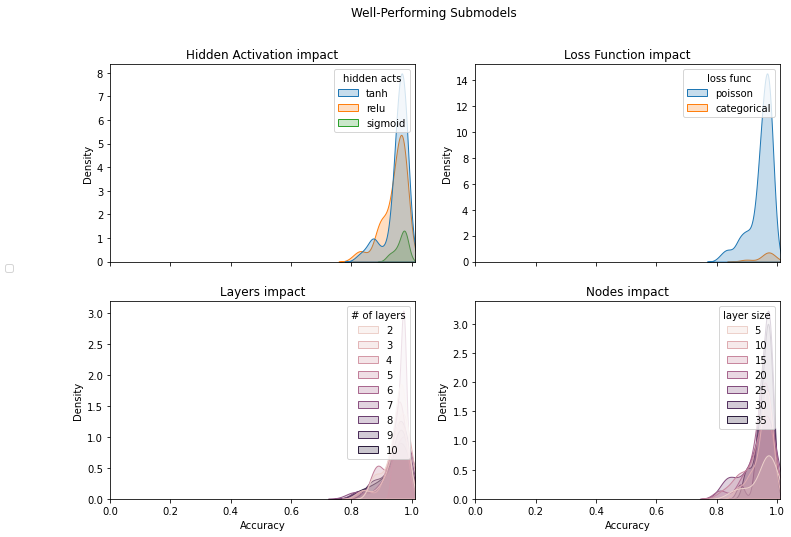

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
sns.kdeplot(ax=axes[0, 0],data=df_act_comp, x="Accuracy", hue="hidden acts", fill=True)
axes[0,0].set_title('Hidden Activation impact')
#axes[0,0].hlines(max(dfy['Accuracy']))
#axes[0,0].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[0,0].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[0,0].set_xlim(0,1.01)


sns.kdeplot(ax=axes[0, 1],data=df_act_comp, x="Accuracy", hue="loss func",fill=True)
axes[0,1].set_title('Loss Function impact')
#axes[0,1].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[0,1].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[0,1].set_xlim(0,1.01)


sns.kdeplot(ax=axes[1, 0],data=df_act_comp, x="Accuracy", hue="# of layers",fill=True)
axes[1,0].set_title('Layers impact')
#axes[1,0].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[1,0].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[1,0].set_xlim(0,1.01)
#axes[1,0].legend(loc='center left')


sns.kdeplot(ax=axes[1, 1],data=df_act_comp, x="Accuracy", hue="layer size",fill=True)
axes[1,1].set_title('Nodes impact')
#axes[1,1].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[1,1].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[1,1].set_xlim(0,1.01)

fig.suptitle('Well-Performing Submodels')
fig.legend(loc='center left')
plt.savefig('../../results/GOOD_SUBMODELS')

In [20]:
hidden_acts = []
losses = []
num_layers = []
layer_size = []

sim_ids = ['2cl2f','2cl8f','2cs2f','2cs8f','3cl2f','3cs2f','3cl8f','3cs8f']
for x in os.listdir('../../data/simulated/simulated_models/'):
    if x.split('_')[-1][:-3] == sim_ids[3]:
        if int(x.split('_')[1]) in list(ids_low):
            act = x.split('_')[2]
            hidden_acts.append(act)
            if x.split('_')[3] == 'categorical':
                losses.append('categorical')
            elif x.split('_')[3] == 'poisson':
                losses.append('poisson')
            n_l = int(x.split('_')[-3])
            num_layers.append(n_l)
            s_l = int(x.split('_')[-2])
            layer_size.append(s_l)


bad_acc = (df.loc[df['Model Accuracy'] <= 0.5]['Model Accuracy'])
bad_loss = (df.loc[df['Model Accuracy'] <= 0.5]['Model Loss'])


df_act_comp_1 = pd.DataFrame(ids_low)
df_act_comp_1['hidden acts'] = hidden_acts
df_act_comp_1['loss func'] = losses
df_act_comp_1['# of layers'] = num_layers
df_act_comp_1['layer size'] = layer_size
df_act_comp_1['Loss'] = bad_loss
df_act_comp_1['Accuracy'] = bad_acc
del df_act_comp_1['Model ID']
df_act_comp_1.head()

,hidden acts,loss func,# of layers,layer size,Loss,Accuracy
0,tanh,categorical,5,5,6.160480e-08,0.476510
2,sigmoid,categorical,6,20,6.160480e-08,0.483221
4,relu,categorical,4,15,6.160480e-08,0.046980
5,relu,categorical,2,25,6.160480e-08,0.483221
6,relu,categorical,2,15,6.160480e-08,0.342282


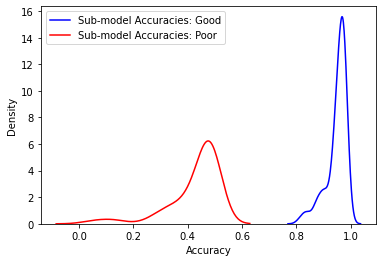

In [22]:
plt.figure()
sns.kdeplot(x='Accuracy', data=df_act_comp, color='blue', label='Sub-model Accuracies: Good')
sns.kdeplot(x='Accuracy', data=df_act_comp_1, color='red', label='Sub-model Accuracies: Poor')
plt.legend()

STACKING MODELS: GOOD

In [23]:
num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [2,5,10]:
    for num_node in [2,5,10]:
        for hidden_act in ['relu', 'sigmoid', 'tanh']:
            for loss in ['categorical_crossentropy', 'poisson', 'binary_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=good_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)

e number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 0.979592
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.959184
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accurac

In [24]:
dicty = {
    "Layers": num_layers,
    "Nodes": num_nodes,
    "Hidden Activation": hidden_acts,
    "Model Loss": losses,
    "Accuracy": accuracies
}

dfy = pd.DataFrame(dicty)
dfy.to_csv('stacking_params_good.csv')

STACKING MODELS: BAD

In [25]:
num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [2,5,10]:
    for num_node in [2,5,10]:
        for hidden_act in ['relu', 'sigmoid', 'tanh']:
            for loss in ['categorical_crossentropy', 'poisson', 'binary_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=bad_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)

e number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 1.000000
Accurac

In [26]:
dicty_2 = {
    "Layers": num_layers,
    "Nodes": num_nodes,
    "Hidden Activation": hidden_acts,
    "Model Loss": losses,
    "Accuracy": accuracies
}

dfy_2 = pd.DataFrame(dicty_2)
dfy_2.to_csv('stacking_params_bad.csv')

COMPARE ALL ACCURACIES

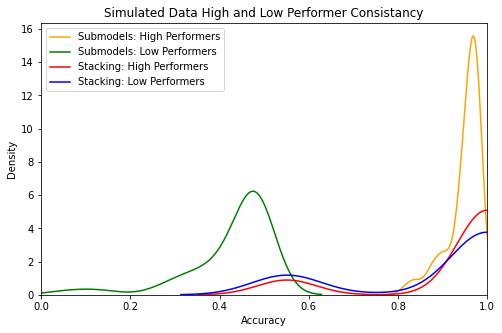

In [40]:
plt.figure(figsize=(8,5))
sns.kdeplot(x='Accuracy', data=df_act_comp, color='orange', label='Submodels: High Performers')
sns.kdeplot(x='Accuracy', data=df_act_comp_1, color='green', label='Submodels: Low Performers')
sns.kdeplot(x='Accuracy', data=dfy, color='red', label='Stacking: High Performers')
sns.kdeplot(x='Accuracy', data=dfy_2, color='blue', label='Stacking: Low Performers')
plt.xlim(0,1.0)
plt.legend()
plt.title('Simulated Data High and Low Performer Consistancy')
plt.savefig('../../results/exp6_all_accuracies')